# 9章：RNN, CNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/NLP100knock2024/chapter09/'

/content/drive/MyDrive/NLP100knock2024/chapter09


## 80. ID番号への変換

In [ ]:
import pandas as pd
from collections import defaultdict
import string


class ID():
    def __init__(self, data):
        #単語と出現頻度を入れる辞書
        self.train_dict = defaultdict(int)
        #単語とIDを入れるリスト
        self.id_list = []
        #単語とIDを入れる辞書
        self.id_dict = dict()
        self.make_id(data)

    def make_id(self, data):
        #dataの単語をカウントした辞書を作る
        for line in data:
            words = line.translate(table).split()
            for word in words:
                # if word != "":
                self.train_dict[word] += 1
        calc_dict = dict(self.train_dict)
        #出現回数で降順にする
        sort_list = sorted(calc_dict.items(), key=lambda x: x[1], reverse=True)
        for i, (trg_word, freq) in enumerate(sort_list):
            #２回以上出現
            if freq >= 2:
                #単語とIDのタプルを入れる。
                self.id_list.append((trg_word, i+1))
            #１回のみ出現
            else:
                self.id_list.append((trg_word, 0))
        self.id_dict = dict(self.id_list)

    def return_id(self, line):
        """ある単語列について単語に分割し、その単語にIDがあればID、そうでなければ0にしたものを返す"""
        one_hot_vec = []
        words = line.strip().split(" ")
        for word in words:
            if word in self.id_dict.keys():
                one_hot_vec.append(self.id_dict[word])
            else:
                one_hot_vec.append(0)
        return one_hot_vec


In [ ]:
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))

header_name = ['TITLE', 'CATEGORY']
train_file = "../chapter06/train.txt"
train_data = pd.read_csv(train_file, header=None,
                         sep='\t', names=header_name)
w2id = ID(train_data['TITLE'])
test_vec = w2id.return_id(train_data["TITLE"][10])


# print(test_vec)
print(w2id.id_dict)

{'to': 1, 's': 2, 'in': 3, 'UPDATE': 4, 'on': 5, 'as': 6, 'US': 7, 'for': 8, 'of': 9, 'The': 10, '1': 11, 'To': 12, '2': 13, 'and': 14, 'the': 15, 'In': 16, 'Of': 17, 'at': 18, 'a': 19, 'A': 20, 'Is': 21, 'With': 22, 'For': 23, 'with': 24, 'And': 25, 'after': 26, '3': 27, 'New': 28, 'Kardashian': 29, 'China': 30, 'On': 31, 'by': 32, 'up': 33, 'Kim': 34, 'After': 35, 'At': 36, 'says': 37, 'is': 38, 'From': 39, 'STOCKS': 40, 'ECB': 41, 't': 42, 'Fed': 43, 'from': 44, 'Says': 45, 'new': 46, '4': 47, 'her': 48, 'Wall': 49, 'shares': 50, 'FOREX': 51, 'Euro': 52, 'data': 53, 'It': 54, 'Cyrus': 55, 'First': 56, 'Miley': 57, 'CEO': 58, '5': 59, 'Dollar': 60, 'West': 61, 'May': 62, 'over': 63, 'Google': 64, 'About': 65, 'St': 66, 'she': 67, 'You': 68, 'S': 69, 'Kanye': 70, 'Up': 71, 'Ukraine': 72, 'bln': 73, 'Over': 74, 'Chris': 75, 'As': 76, 'Stocks': 77, 'Be': 78, 'off': 79, 'More': 80, 'Will': 81, 'I': 82, 'Billion': 83, 'Justin': 84, 'Apple': 85, 'Bank': 86, 'Bieber': 87, 'UK': 88, 'euro': 

## 81. RNNによる予測

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset


class RNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size):
        super().__init__()
        self.hid_size = hidden_size
        #単語の埋め込み
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx) #vocab_size:語彙サイズ、emb_size:埋め込み次元、padding_idx：無視するID
        #RNNを構築
        self.rnn = nn.RNN(emb_size, hidden_size, #input_size:入力サイズ、hidden_size:隠れ層hにおける特徴量数
                          nonlinearity="tanh", batch_first=True) #nonlinearity:非線形変換、batch_first:入出力の最初をbatchにする
        #出力
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = torch.zeros(1, self.batch_size, self.hid_size)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out


class NewsDataset(Dataset):
    def __init__(self, x, y, tokenizer):
        self.x = x
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.y)

    #token化してテンソルにしたinputとlabelの辞書を返す
    def __getitem__(self, idx):
                text = self.x[idx]
        inputs = self.tokenizer(text)

        return {
            'inputs': torch.tensor(inputs, dtype=torch.int64),
            'labels': torch.tensor(self.y[idx], dtype=torch.int64)
        }


In [ ]:
train = pd.read_csv("../chapter08/train.txt", sep='\t')
valid = pd.read_csv("../chapter08/valid.txt", sep='\t')
test = pd.read_csv("../chapter08/test.txt", sep='\t')


category = {'b': 0, 't': 1, 'e': 2, 'm': 3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category[x]).values)


dataset_train = NewsDataset(train["TITLE"], y_train, w2id.return_id)
dataset_valid = NewsDataset(valid["TITLE"], y_valid, w2id.return_id)
dataset_test = NewsDataset(test["TITLE"], y_test, w2id.return_id)


print(f'len(Dataset): {len(dataset_train)}')
print('Dataset[index]:')
for var in dataset_train[1]:
    print(f'  {var}: {dataset_train[1][var]}')

len(Dataset): 10684
Dataset[index]:
  inputs: tensor([  70,   61,    0,   70,   61, 5132,   36, 1443,  404])
  labels: 2


<ipython-input-6-941f45d00045>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


In [ ]:
VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

model = RNN(HIDDEN_SIZE, VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE)
for i in range(10):
    X = dataset_train[i]['inputs']
    print(torch.softmax(model(X.unsqueeze(0)), dim=-1)) #unsqueezeで次元0に新しい次元を挿入

tensor([[0.2813, 0.2903, 0.2168, 0.2116]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4108, 0.2263, 0.2396, 0.1233]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2093, 0.2969, 0.3092, 0.1846]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1770, 0.3819, 0.2715, 0.1696]], grad_fn=<SoftmaxBackward0>)


<ipython-input-6-941f45d00045>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


tensor([[0.2138, 0.2924, 0.3069, 0.1870]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2036, 0.2986, 0.2432, 0.2547]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3003, 0.1774, 0.3136, 0.2087]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2199, 0.2565, 0.3413, 0.1823]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2161, 0.3815, 0.2544, 0.1480]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3545, 0.1976, 0.1808, 0.2672]], grad_fn=<SoftmaxBackward0>)


## 82. 確率的勾配降下法による学習

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import time
from torch.utils.data import DataLoader


def calc_loss_acc(model, dataset, device=None, criterion=None):
    # model.eval()
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            #GPUがつかえるなら
            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)

            if criterion != None:
                loss += criterion(outputs, labels).item()

            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()

        return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion,  optimizer, num_epochs, device=None):

    model.to(device)

    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=1, shuffle=False)
    # dataloader_valid = DataLoader(
    #     dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        start_time = time.time()
        #訓練モード
        model.train()
        loss_train = 0.0
        for data in dataloader_train:
            optimizer.zero_grad()
            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        end_time = time.time()

        #検証モード
        model.eval()
        loss_train, acc_train = calc_loss_acc(
            model, dataset_train, device, criterion=criterion)
        loss_valid, acc_valid = calc_loss_acc(
            model, dataset_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, train_time: {(end_time - start_time):.4f}sec')
    return {
        "train": log_train,
        "valid": log_valid
    }


def visualize_logs(log, number):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(np.array(log['train']).T[0], label='train')
    ax[0].plot(np.array(log['valid']).T[0], label='valid')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[0].legend()
    ax[1].plot(np.array(log['train']).T[1], label='train')
    ax[1].plot(np.array(log['valid']).T[1], label='valid')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()
    plt.savefig(f"{number}.png")


<ipython-input-6-941f45d00045>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1, loss_train: 1.0855, accuracy_train: 0.5611, loss_valid: 1.1320, accuracy_valid: 0.5337, train_time: 60.2487sec
epoch: 2, loss_train: 1.0175, accuracy_train: 0.6008, loss_valid: 1.0915, accuracy_valid: 0.5531, train_time: 58.9122sec
epoch: 3, loss_train: 0.9394, accuracy_train: 0.6392, loss_valid: 1.0109, accuracy_valid: 0.6033, train_time: 59.0017sec
epoch: 4, loss_train: 0.8131, accuracy_train: 0.7028, loss_valid: 0.8853, accuracy_valid: 0.6759, train_time: 61.3788sec
epoch: 5, loss_train: 0.6892, accuracy_train: 0.7571, loss_valid: 0.7917, accuracy_valid: 0.7171, train_time: 63.3126sec
epoch: 6, loss_train: 0.6271, accuracy_train: 0.7781, loss_valid: 0.7591, accuracy_valid: 0.7246, train_time: 63.3606sec
epoch: 7, loss_train: 0.5540, accuracy_train: 0.7994, loss_valid: 0.7148, accuracy_valid: 0.7358, train_time: 61.6685sec
epoch: 8, loss_train: 0.5237, accuracy_train: 0.8082, loss_valid: 0.6924, accuracy_valid: 0.7463, train_time: 60.6764sec
epoch: 9, loss_train: 0.5126, ac

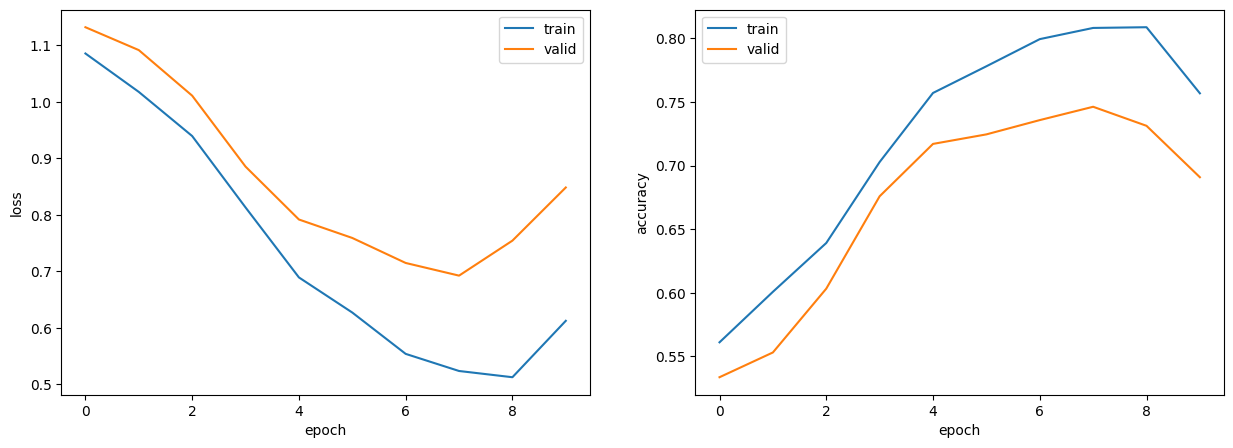

In [ ]:
VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

model = RNN(HIDDEN_SIZE, VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
log = train_model(dataset_train, dataset_valid, BATCH_SIZE,
                  model, criterion, optimizer, NUM_EPOCHS)
visualize_logs(log, 82)
_, acc_train = calc_loss_acc(model, dataset_train)
_, acc_test = calc_loss_acc(model, dataset_test)
print(f'accuracy (train)：{acc_train:.3f}')
print(f'accuracy (test)：{acc_test:.3f}')

## 83. ミニバッチ化・GPU上での学習

In [ ]:
class RNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size, device): #deviceを追加
        super().__init__()
        self.hid_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(emb_size, hidden_size,
                          nonlinearity="tanh", batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = torch.zeros(1, self.batch_size, self.hid_size, device=device)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out


def train_model(dataset_train, dataset_valid, batch_size, model, criterion,  optimizer, num_epochs, device=None, collate_fn=None): #batch_size, divice, collate_fnを追加
    model.to(device)

    dataloader_train = DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_valid = DataLoader(
        dataset_valid, batch_size=1, shuffle=False)
    # dataloader_valid = DataLoader(
    #     dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    log_train = []
    log_valid = []

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        loss_train = 0.0
        for data in dataloader_train:
            optimizer.zero_grad()

            inputs = data["inputs"].to(device)
            labels = data["labels"].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        end_time = time.time()

        model.eval()
        loss_train, acc_train = calc_loss_acc(
            model, dataset_train, device, criterion=criterion)
        loss_valid, acc_valid = calc_loss_acc(
            model, dataset_valid, device, criterion=criterion)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(
        ), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, train_time: {(end_time - start_time):.4f}sec')
    return {
        "train": log_train,
        "valid": log_valid
    }

#可変長のシーケンスデータをパディングして同じ長さに揃える
class Padseq():
    def __init__(self, padding_idx):
        self.padding_idx = padding_idx

    def __call__(self, batch):
        sorted_batch = sorted(
            batch, key=lambda x: x['inputs'].shape[0], reverse=True)
        sequences = [x['inputs'] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(
            sequences, batch_first=True, padding_value=self.padding_idx)
        labels = torch.LongTensor([x['labels'] for x in sorted_batch])

        return {'inputs': sequences_padded, 'labels': labels}

<ipython-input-6-941f45d00045>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1, loss_train: 1.2696, accuracy_train: 0.4418, loss_valid: 1.3019, accuracy_valid: 0.4251, train_time: 2.5297sec
epoch: 2, loss_train: 1.2341, accuracy_train: 0.4666, loss_valid: 1.2670, accuracy_valid: 0.4484, train_time: 1.4366sec
epoch: 3, loss_train: 1.2346, accuracy_train: 0.4693, loss_valid: 1.2780, accuracy_valid: 0.4469, train_time: 1.0679sec
epoch: 4, loss_train: 1.2644, accuracy_train: 0.4224, loss_valid: 1.2929, accuracy_valid: 0.3937, train_time: 1.0863sec
epoch: 5, loss_train: 1.2156, accuracy_train: 0.4876, loss_valid: 1.2619, accuracy_valid: 0.4760, train_time: 1.0993sec
epoch: 6, loss_train: 1.0842, accuracy_train: 0.5530, loss_valid: 1.1126, accuracy_valid: 0.5217, train_time: 1.1015sec
epoch: 7, loss_train: 1.1087, accuracy_train: 0.5389, loss_valid: 1.1379, accuracy_valid: 0.5112, train_time: 1.1699sec
epoch: 8, loss_train: 1.1287, accuracy_train: 0.5397, loss_valid: 1.1792, accuracy_valid: 0.5195, train_time: 1.5263sec
epoch: 9, loss_train: 0.9514, accuracy_t

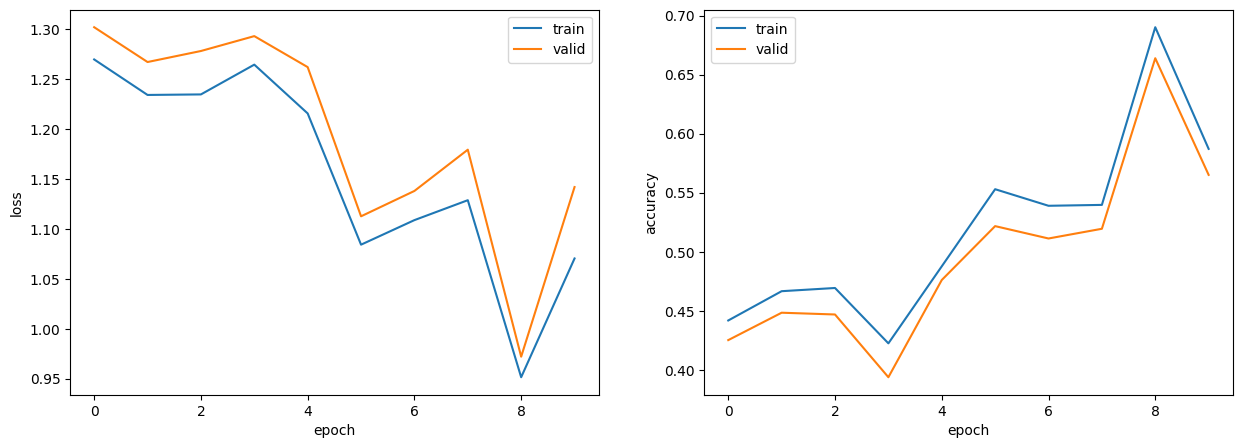

In [ ]:
VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

device = torch.device('cuda')


model = RNN(HIDDEN_SIZE, VOCAB_SIZE, EMB_SIZE,
            PADDING_IDX, OUTPUT_SIZE, device)

criterion = nn.CrossEntropyLoss()

#確率的勾配降下法を最適化手法に用いる
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion,
                  optimizer, NUM_EPOCHS, device=device, collate_fn=Padseq(PADDING_IDX))

visualize_logs(log, 83)
_, acc_train = calc_loss_acc(model, dataset_train, device)
_, acc_test = calc_loss_acc(model, dataset_test, device)
print(f'accuracy (train)：{acc_train:.3f}')
print(f'accuracy (test)：{acc_test:.3f}')

## 84. 単語ベクトルの導入

In [ ]:
#事前学習済み単語ベクトルで単語埋め込みを初期化
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(
    '../chapter07/GoogleNews-vectors-negative300.bin.gz', binary=True)

VOCAB_SIZE = len(set(w2id.id_dict.keys())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(w2id.id_dict.keys()):
    try:
        weights[i] = model[word]
        words_in_pretrained += 1
    except KeyError:
        weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'learned word num: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

learned word num: 16349 / 17056
torch.Size([17056, 300])


<ipython-input-6-941f45d00045>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1, loss_train: 1.4018, accuracy_train: 0.3990, loss_valid: 1.4342, accuracy_valid: 0.3960, train_time: 1.6298sec
epoch: 2, loss_train: 1.2987, accuracy_train: 0.4116, loss_valid: 1.3315, accuracy_valid: 0.3937, train_time: 1.0818sec
epoch: 3, loss_train: 1.3163, accuracy_train: 0.4320, loss_valid: 1.3736, accuracy_valid: 0.4117, train_time: 1.1377sec
epoch: 4, loss_train: 1.2369, accuracy_train: 0.4925, loss_valid: 1.2782, accuracy_valid: 0.4760, train_time: 1.0932sec
epoch: 5, loss_train: 1.1479, accuracy_train: 0.5450, loss_valid: 1.1622, accuracy_valid: 0.5427, train_time: 1.5935sec
epoch: 6, loss_train: 1.2949, accuracy_train: 0.4955, loss_valid: 1.3778, accuracy_valid: 0.4701, train_time: 1.2419sec
epoch: 7, loss_train: 1.2136, accuracy_train: 0.5249, loss_valid: 1.2813, accuracy_valid: 0.4925, train_time: 1.1078sec
epoch: 8, loss_train: 1.1612, accuracy_train: 0.5688, loss_valid: 1.2255, accuracy_valid: 0.5352, train_time: 1.1028sec
epoch: 9, loss_train: 1.1317, accuracy_t

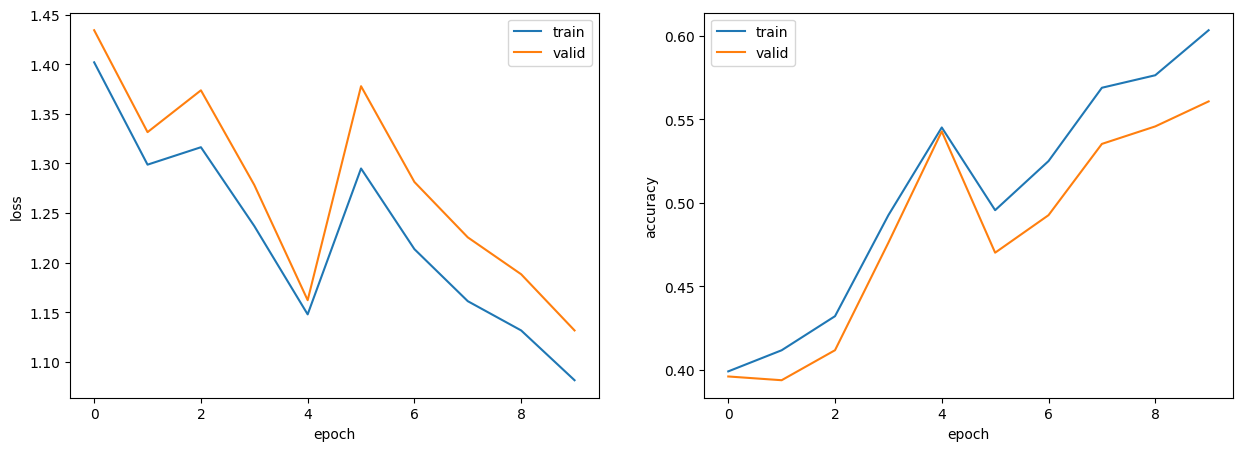

In [ ]:
class RNN(nn.Module):
    def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size, device, num_layers, emb_weight=None, bidirectional=False): #emb_weight, bidirectionalを追加
        super().__init__()
        self.hid_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = bidirectional + 1
        if emb_weight != None:
            self.emb = nn.Embedding.from_pretrained(
                emb_weight, padding_idx=pad_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        # self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=pad_idx)
        self.rnn = nn.RNN(emb_size, hidden_size, num_layers,
                          nonlinearity="tanh", batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = torch.zeros(self.num_layers * self.num_directions,
                             self.batch_size, self.hid_size, device=device)
        emb = self.emb(x)
        out, hidden = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out


VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

device = torch.device('cuda')

# def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size, device, num_layers, emb_weight=None, bidirectional=False):
model = RNN(HIDDEN_SIZE, VOCAB_SIZE, EMB_SIZE, PADDING_IDX,
            OUTPUT_SIZE, device, NUM_LAYERS, emb_weight=weights) #emb_weightsにweightsを指定

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion,
                  optimizer, NUM_EPOCHS, device=device, collate_fn=Padseq(PADDING_IDX))

visualize_logs(log, 84)
_, acc_train = calc_loss_acc(model, dataset_train, device)
_, acc_test = calc_loss_acc(model, dataset_test, device)
print(f'accuracy (train)：{acc_train:.3f}')
print(f'accuracy (test)：{acc_test:.3f}')

## 85. 双方向RNN・多層化

<ipython-input-6-941f45d00045>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(self.y[idx], dtype=torch.int64)


epoch: 1, loss_train: 1.3767, accuracy_train: 0.3990, loss_valid: 1.4213, accuracy_valid: 0.3967, train_time: 1.2623sec
epoch: 2, loss_train: 1.3828, accuracy_train: 0.4058, loss_valid: 1.4399, accuracy_valid: 0.3967, train_time: 1.2409sec
epoch: 3, loss_train: 1.3664, accuracy_train: 0.4301, loss_valid: 1.4273, accuracy_valid: 0.4132, train_time: 1.2693sec
epoch: 4, loss_train: 1.0863, accuracy_train: 0.5794, loss_valid: 1.1071, accuracy_valid: 0.5636, train_time: 1.2487sec
epoch: 5, loss_train: 1.1142, accuracy_train: 0.5710, loss_valid: 1.1676, accuracy_valid: 0.5412, train_time: 1.2445sec
epoch: 6, loss_train: 1.2919, accuracy_train: 0.4812, loss_valid: 1.3537, accuracy_valid: 0.4611, train_time: 1.4231sec
epoch: 7, loss_train: 1.1823, accuracy_train: 0.5033, loss_valid: 1.2382, accuracy_valid: 0.4783, train_time: 1.8528sec
epoch: 8, loss_train: 1.3234, accuracy_train: 0.4832, loss_valid: 1.4158, accuracy_valid: 0.4648, train_time: 1.6810sec
epoch: 9, loss_train: 1.2388, accuracy_t

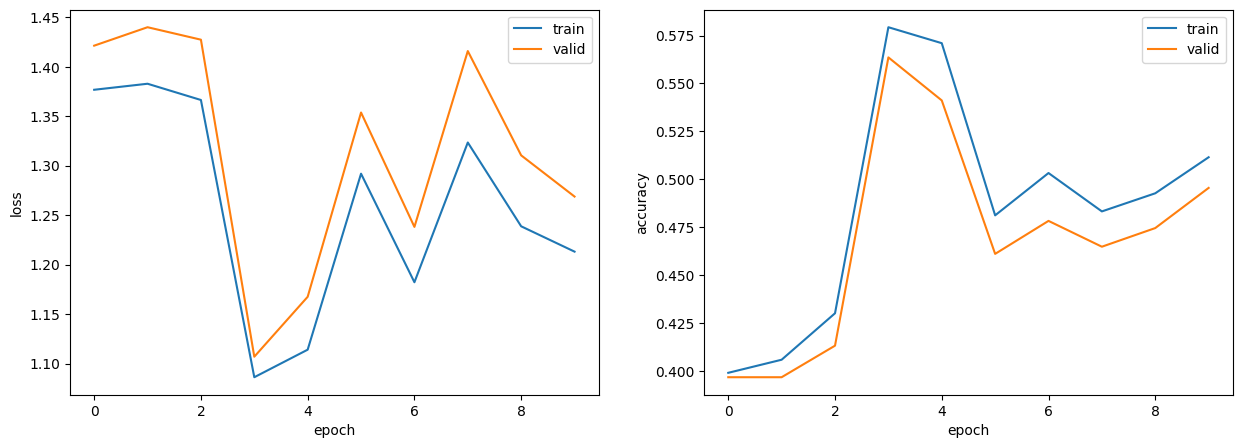

In [ ]:
VOCAB_SIZE = len(set(w2id.id_dict.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(w2id.id_dict.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

device = torch.device('cuda')

# def __init__(self, hidden_size, vocab_size, emb_size, pad_idx, output_size, device, num_layers, emb_weight=None, bidirectional=False):
model = RNN(HIDDEN_SIZE, VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE,
            device, NUM_LAYERS, emb_weight=weights, bidirectional=True) #bidirectionalをTrueに

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion,
                  optimizer, NUM_EPOCHS, device=device, collate_fn=Padseq(PADDING_IDX))

visualize_logs(log, 85)
_, acc_train = calc_loss_acc(model, dataset_train, device)
_, acc_test = calc_loss_acc(model, dataset_test, device)
print(f'accuracy (train)：{acc_train:.3f}')
print(f'accuracy (test)：{acc_test:.3f}')

#多層化は実験せず